# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Constants for columns
DEATH_COLUMN = 'dead'
RUNNING_MORALITY_PERCENTAGE_COLUMN = 'cumulative deaths %'
PROBABILITY_OF_DEATH_PER_PERIOD_COLUMN = 'p(death per time period)'
AGE_IN_DAYS_COLUMN = 'age(days)'

# Constants for column values
CONTROL_GROUP_KEY = 'Control'

In [3]:
df = pd.read_csv(
    "Lifespans_ITP1.csv",
    skiprows=0,
    sep=";",
    index_col=[0, 1],
    skipfooter=0,
    engine="python",
    decimal=",",
)

### 1. Data Preprocessing
In our project, we are using the data sets from the [Interventions Testing Program](https://phenome.jax.org/projects/ITP1) and merging their data sets together into one big CSV file.

We humans are animals who are following the rules of nature. One rule is that organisms are aging and have a finite lifespan.
With age, specific repair processes no longer function properly, which means that damage to the genetic material, cells, and tissues continues to accumulate (see [1](https://www.age.mpg.de/wie-altern-wir)). 
 
The Interventions Testing Program is a study that investigates treatments to increase the life span for humans. In science, it is common to experiment with mice to approximate the effect of a substance on a human. For their experiments they are using heterogeneous populations of UM-HET3 mice. The mice in the test population share half of the genes so that they can be seen as siblings. That is done for the reproducibility and consistency of the genetics of the mice (see [2](https://arc.net/l/quote/clbxozpq)).

In [4]:
control_group = df.loc[df['group'] == CONTROL_GROUP_KEY]
control_group = control_group.sort_values(by=[AGE_IN_DAYS_COLUMN])
control_group

site sex       id    group Rx(ppm) age_initiation(mo)  \
population cohort                                                         
UM-HET3    C2005    UT   f  UT01531  Control       0                NaN   
           C2004    UT   m  UT00803  Control       0                NaN   
           C2005    UT   f  UT01532  Control       0                NaN   
           C2005    UT   f  UT01529  Control       0                NaN   
           C2005    UT   f  UT01530  Control       0                NaN   
...                ...  ..      ...      ...     ...                ...   
           C2007   TJL   f  JL03117  Control     0.0                NaN   
           C2014   TJL   f  JL11157  Control     0.0                NaN   
           C2007    UM   f  UM23597  Control     0.0                NaN   
           C2015   TJL   f  JL12242  Control       0                NaN   
           C2011    UM   f  UM38745  Control       0                NaN   

                    status  dead  age(days)  
population cohort                            
UM-HET3    C2005   removed     0         27  
           C2004      dead     1         27  
           C2005   removed     0         27  
           C2005   removed     0         29  
           C2005   removed     0         29  
...                    ...   ...        ...  
           C2007      dead     1       1340  
           C2014      dead     1       1358  
           C2007      dead     1       1359  
           C2015      dead     1       1396  
           C2011      dead     1       1456  

[7815 rows x 9 columns]

We calc the probability of death for each time period.

In [16]:
time_period_in_days = 100

def group_same_ages(data) -> pd.DataFrame:
    return data.groupby(AGE_IN_DAYS_COLUMN).sum()

def group_ages(data: pd.DataFrame, time_period_in_days: int) -> pd.DataFrame:
    data = data[[DEATH_COLUMN, AGE_IN_DAYS_COLUMN]]

    data = group_same_ages(data)
    
    group_days_by_time_period = lambda x: (x // time_period_in_days)
    groupped_data_by_time_period = data.groupby(group_days_by_time_period).sum()

    index_name = f'age({time_period_in_days} days)'
    groupped_data_by_time_period.index.name = index_name
    return groupped_data_by_time_period

def calculate_running_alive_counts(data: pd.DataFrame) -> pd.DataFrame:
    total = calculate_total(data)
    running_alive = total - data.cumsum()

    # Start dataset with all alive and drop the last column to maintain same
    # shape as before
    running_alive.index += 1
    running_alive = pd.concat([pd.DataFrame([total]), running_alive])[:-1]

    return running_alive

def calculate_total(data: pd.DataFrame) -> pd.DataFrame:
    return data.sum()

def compute_chance_of_death_per_time_period(dead_counts: pd.DataFrame,
                                            running_alive_counts: pd.DataFrame) -> pd.DataFrame:
    return dead_counts / (running_alive_counts + 1e-9)

dead_counts = group_ages(control_group, time_period_in_days)
running_alive_counts = calculate_running_alive_counts(dead_counts)
chance_of_death_per_time_period = compute_chance_of_death_per_time_period(dead_counts, running_alive_counts)

chance_of_death_per_time_period

,dead
age(100 days),
0,0.000815
1,0.003125
2,0.015674
3,0.034201
4,0.045878
5,0.065515
6,0.128638
7,0.199299
8,0.343628


We make a plot.

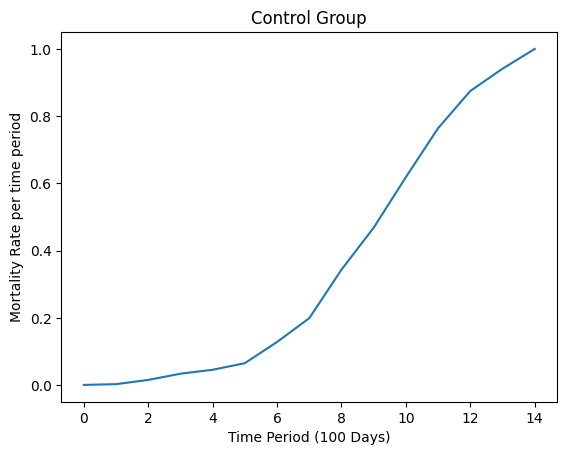

In [6]:
def graph_chance_of_death_per_time_period(chance_of_death_per_time_period: pd.DataFrame,
                                          time_period_in_days: int,
                                          title: str) -> None: 
    plt.plot(chance_of_death_per_time_period)
    plt.xlabel(f'Time Period ({time_period_in_days} Days)')
    plt.ylabel(f'Mortality Rate per time period')
    plt.title(title)
    plt.show()

graph_chance_of_death_per_time_period(chance_of_death_per_time_period, time_period_in_days, 'Control Group')

In [17]:
def calculate_cumulative_deaths(data):
    return data[DEATH_COLUMN].cumsum()

def compute_total_deaths(cumulative_deaths):
    return cumulative_deaths.iloc[-1]

def compute_running_mortality_percentage(data):
    cumulative_deaths = calculate_cumulative_deaths(data)
    total_deaths = compute_total_deaths(cumulative_deaths)
    
    if total_deaths == 0:
        raise ValueError('Invalid dataset (# of deaths must be > 0)')

    return cumulative_deaths / total_deaths

running_mortality_percentage = compute_running_mortality_percentage(control_group)
control_group.loc[:, RUNNING_MORALITY_PERCENTAGE_COLUMN] = running_mortality_percentage
control_group[[AGE_IN_DAYS_COLUMN, RUNNING_MORALITY_PERCENTAGE_COLUMN]]

age(days)  cumulative deaths %
population cohort                                
UM-HET3    C2005          27             0.000000
           C2004          27             0.000136
           C2005          27             0.000136
           C2005          29             0.000136
           C2005          29             0.000136
...                      ...                  ...
           C2007        1340             0.999457
           C2014        1358             0.999593
           C2007        1359             0.999728
           C2015        1396             0.999864
           C2011        1456             1.000000

[7815 rows x 2 columns]

Make a plot of the cummulative mortality percentage.

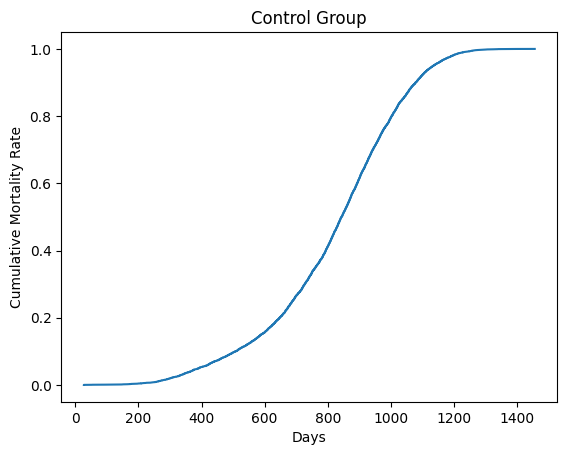

In [8]:
def graph_running_mortality_percentage(experiment_group: pd.DataFrame, title: str) -> None: 
    age_in_days = experiment_group.loc[:, AGE_IN_DAYS_COLUMN]
    running_mortality_percentage = experiment_group.loc[:, RUNNING_MORALITY_PERCENTAGE_COLUMN]
    
    plt.plot(age_in_days, running_mortality_percentage)
    plt.xlabel('Days')
    plt.ylabel('Cumulative Mortality Rate')
    plt.title(title)
    plt.show()

graph_running_mortality_percentage(control_group, title='Control Group')